# ANL Hall Probe First Look

## Imports etc.

In [2]:
import sys
print(sys.executable)

/home/ckampa/anaconda3/envs/bfitter/bin/python


Should check, but I believe axis 0 is rotated by +pi/2 for runs 0 & 1 (e.g. 0 deg in runs 0,1 = 90 deg in run 2)

In [3]:
%load_ext autoreload
%autoreload 2

In [185]:
# hallprobecalib functions
from hallprobecalib import hpc_ext_path
from hallprobecalib.hallrawdataframe import HallRawDataFrame
from hallprobecalib.scatter3d import Scatter3d
from hallprobecalib.contour2d import Contour2d

# external packages
import numpy as np
import pandas as pd
import math
from scipy.interpolate import griddata
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import mpl_toolkits.mplot3d as Axes3d
import os
import re
from sys import getsizeof
from IPython.html.widgets import interact, widgets
# plotly!
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as FF
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

plt.rcParams['figure.figsize'] = (6.0, 4.0)

## Select Data for Same Probe
- This should be made to be a standard import function in hallprobecalib.

### Regex for picking proper filenames

In [5]:
r = re.compile("raw\.ckampa\.hallprobecal\.tagMA124.*\.txt$")

In [6]:
direct = hpc_ext_path + 'datafiles/'

In [7]:
same_probe = [f.replace('.txt','') for f in os.listdir(direct) if r.match(f)]

In [8]:
same_probe

['raw.ckampa.hallprobecal.tagMA12411.2018-12-03_113432',
 'raw.ckampa.hallprobecal.tagMA12411.2018-11-29_123435',
 'raw.ckampa.hallprobecal.tagMA12421.2018-11-29_135237',
 'raw.ckampa.hallprobecal.tagMA12411.2018-11-29_113332',
 'raw.ckampa.hallprobecal.tagMA12411.2018-12-03_123641',
 'raw.ckampa.hallprobecal.tagMA12411.2018-12-03_115928',
 'raw.ckampa.hallprobecal.tagMA12411.2018-11-29_113749',
 'raw.ckampa.hallprobecal.tagMA12411.2018-12-03_130522']

In [9]:
sorted(same_probe)

['raw.ckampa.hallprobecal.tagMA12411.2018-11-29_113332',
 'raw.ckampa.hallprobecal.tagMA12411.2018-11-29_113749',
 'raw.ckampa.hallprobecal.tagMA12411.2018-11-29_123435',
 'raw.ckampa.hallprobecal.tagMA12411.2018-12-03_113432',
 'raw.ckampa.hallprobecal.tagMA12411.2018-12-03_115928',
 'raw.ckampa.hallprobecal.tagMA12411.2018-12-03_123641',
 'raw.ckampa.hallprobecal.tagMA12411.2018-12-03_130522',
 'raw.ckampa.hallprobecal.tagMA12421.2018-11-29_135237']

In [10]:
f = 'raw.ckampa.hallprobecal.tagMA12411.2018-11-29_113332'
f.split('.')[-1]

'2018-11-29_113332'

In [11]:
# sort by date, not key! this will be helpful for concat later :)
same_probe = sorted(same_probe, key = lambda x: x.split('.')[-1])

In [12]:
same_probe

['raw.ckampa.hallprobecal.tagMA12411.2018-11-29_113332',
 'raw.ckampa.hallprobecal.tagMA12411.2018-11-29_113749',
 'raw.ckampa.hallprobecal.tagMA12411.2018-11-29_123435',
 'raw.ckampa.hallprobecal.tagMA12421.2018-11-29_135237',
 'raw.ckampa.hallprobecal.tagMA12411.2018-12-03_113432',
 'raw.ckampa.hallprobecal.tagMA12411.2018-12-03_115928',
 'raw.ckampa.hallprobecal.tagMA12411.2018-12-03_123641',
 'raw.ckampa.hallprobecal.tagMA12411.2018-12-03_130522']

### Load data into list of DataFrames

In [13]:
df = []
meta = []
for fname in same_probe:
    df_,meta_ = HallRawDataFrame(f'datafiles/{fname}', frompickle=True)
    df.append(df_.query('ID_NAME == "linus"')
              .reset_index(drop=True)
              .assign(Run=same_probe.index(fname)))
    meta.append(meta_)

In [14]:
print(f'{len(df)} files')
f = 0
for d in df:
    f += getsizeof(d)
print(f'{f/1000/1000} MB')

8 files
2.208747 MB


In [15]:
# did our query for the correct probe work? yes!
for d in df:
    print(d.query('ID_NAME == "linus"').equals(d))

True
True
True
True
True
True
True
True


In [16]:
# do all columns match? should find a way to check and 
# delete columns that do not match in all sets...future code update!
cols = np.array([])
for d in df:
    cols = np.append(cols,d.columns)
print(np.unique(cols))

['AX0_DEG' 'AX0_PAT' 'AX1_DEG' 'AX1_PAT' 'BX_CAL' 'BX_RAW' 'BY_CAL'
 'BY_RAW' 'BZ_CAL' 'BZ_RAW' 'B_MAG_CAL' 'B_MAG_RAW' 'DATETIME' 'FFT_MAX'
 'ID' 'ID_NAME' 'NMR_B_AVG' 'Run' 'TEMP']


In [17]:
first_datetime = []
for d in df:
    first_datetime.append(d.DATETIME[0])

In [18]:
# now that datetime is fixed, this is good!
for d in first_datetime:
    print([d<i for i in first_datetime])

[False, True, True, True, True, True, True, True]
[False, False, True, True, True, True, True, True]
[False, False, False, True, True, True, True, True]
[False, False, False, False, True, True, True, True]
[False, False, False, False, False, True, True, True]
[False, False, False, False, False, False, True, True]
[False, False, False, False, False, False, False, True]
[False, False, False, False, False, False, False, False]


In [19]:
same_probe

['raw.ckampa.hallprobecal.tagMA12411.2018-11-29_113332',
 'raw.ckampa.hallprobecal.tagMA12411.2018-11-29_113749',
 'raw.ckampa.hallprobecal.tagMA12411.2018-11-29_123435',
 'raw.ckampa.hallprobecal.tagMA12421.2018-11-29_135237',
 'raw.ckampa.hallprobecal.tagMA12411.2018-12-03_113432',
 'raw.ckampa.hallprobecal.tagMA12411.2018-12-03_115928',
 'raw.ckampa.hallprobecal.tagMA12411.2018-12-03_123641',
 'raw.ckampa.hallprobecal.tagMA12411.2018-12-03_130522']

In [20]:
first_datetime

[Timestamp('2018-11-29 11:34:40'),
 Timestamp('2018-11-29 11:38:35'),
 Timestamp('2018-11-29 12:34:59'),
 Timestamp('2018-11-29 13:58:41'),
 Timestamp('2018-12-03 11:36:37'),
 Timestamp('2018-12-03 12:00:11'),
 Timestamp('2018-12-03 12:37:38'),
 Timestamp('2018-12-03 13:06:55')]

In [21]:
sorted(first_datetime)

[Timestamp('2018-11-29 11:34:40'),
 Timestamp('2018-11-29 11:38:35'),
 Timestamp('2018-11-29 12:34:59'),
 Timestamp('2018-11-29 13:58:41'),
 Timestamp('2018-12-03 11:36:37'),
 Timestamp('2018-12-03 12:00:11'),
 Timestamp('2018-12-03 12:37:38'),
 Timestamp('2018-12-03 13:06:55')]

In [22]:
df[0]

,DATETIME,NMR_B_AVG,FFT_MAX,AX0_DEG,AX1_DEG,AX0_PAT,AX1_PAT,BX_RAW,BY_RAW,BZ_RAW,B_MAG_RAW,BX_CAL,BY_CAL,BZ_CAL,B_MAG_CAL,TEMP,ID,ID_NAME,Run
0,2018-11-29 11:34:40,1.449541,236.072342,354.999993,354.999995,-5.0,-5.000000,3016267.0,-2695666.0,-133468.0,4.047505e+06,0.045910,-0.966670,-1.078571,1.449094,21.977,C80000000D554B3A,linus,0
1,2018-11-29 11:35:00,1.449541,235.686707,354.999996,355.526317,-5.0,-4.473684,3213580.0,-2445906.0,216182.0,4.044291e+06,-0.080354,-0.878748,-1.149459,1.449107,22.206,C80000000D554B3A,linus,0


In [23]:
# let's try to concatenate our dataframes for one nice dataframe :)
df = pd.concat(df, join='outer', ignore_index=True, sort = False)

In [24]:
df.head()

,DATETIME,NMR_B_AVG,FFT_MAX,AX0_DEG,AX1_DEG,AX0_PAT,AX1_PAT,BX_RAW,BY_RAW,BZ_RAW,B_MAG_RAW,BX_CAL,BY_CAL,BZ_CAL,B_MAG_CAL,TEMP,ID,ID_NAME,Run
0,2018-11-29 11:34:40,1.449541,236.072342,354.999993,354.999995,-5.0,-5.000000,3016267.0,-2695666.0,-133468.0,4.047505e+06,0.045910,-0.966670,-1.078571,1.449094,21.977,C80000000D554B3A,linus,0
1,2018-11-29 11:35:00,1.449541,235.686707,354.999996,355.526317,-5.0,-4.473684,3213580.0,-2445906.0,216182.0,4.044291e+06,-0.080354,-0.878748,-1.149459,1.449107,22.206,C80000000D554B3A,linus,0
2,2018-11-29 11:38:35,0.000000,0.000000,354.999996,354.999998,-5.0,-5.000000,3014896.0,-2696193.0,-133263.0,4.046828e+06,0.045839,-0.966992,-1.078243,1.449063,22.328,C80000000D554B3A,linus,1
3,2018-11-29 11:38:42,1.449541,4.312603,354.999996,355.526311,-5.0,-4.473684,3226001.0,-2446412.0,216200.0,4.054474e+06,-0.080408,-0.878990,-1.153846,1.452739,22.356,C80000000D554B3A,linus,1
4,2018-11-29 11:38:48,1.449541,3.370754,354.999997,356.052634,-5.0,-3.947368,3189997.0,-2476087.0,216451.0,4.044000e+06,-0.080319,-0.889368,-1.141278,1.449118,22.361,C80000000D554B3A,linus,1


In [25]:
getsizeof(df)/1000/1000

4.309546

In [26]:
df.describe()

,NMR_B_AVG,FFT_MAX,AX0_DEG,AX1_DEG,AX0_PAT,AX1_PAT,BX_RAW,BY_RAW,BZ_RAW,B_MAG_RAW,BX_CAL,BY_CAL,BZ_CAL,B_MAG_CAL,TEMP,Run
count,15902.000000,15892.000000,15902.000000,15902.000000,15902.000000,15902.000000,1.590200e+04,1.590200e+04,1.590200e+04,1.590200e+04,15902.000000,15902.000000,15902.000000,15902.000000,15902.000000,15902.000000
mean,1.440044,4.274800,170.949681,163.764420,-0.000633,-0.000600,1.056806e+06,-3.273130e+05,-1.595357e+05,4.082764e+06,0.054449,-0.119804,-0.377662,1.449266,23.977559,3.137970
std,0.115722,2.684370,109.706847,80.548416,99.726334,99.726332,2.160035e+06,1.610211e+06,2.857246e+06,4.330359e+04,1.002452,0.575687,0.777319,0.002010,0.439494,0.865646
min,0.000000,0.000000,0.000932,0.058362,-180.000000,-180.000000,-4.069778e+06,-4.100215e+06,-4.154924e+06,3.919176e+06,-1.448584,-1.449288,-1.449093,1.410521,21.977000,0.000000
25%,1.449498,3.872074,80.168059,145.786698,-80.168070,-80.168070,-4.921558e+05,-1.337176e+06,-3.027124e+06,4.049950e+06,-0.941767,-0.486225,-1.059276,1.449113,23.647000,3.000000
50%,1.449498,4.184043,157.129676,164.992273,-0.131578,-0.131578,1.495882e+06,-3.361810e+05,-1.102415e+05,4.074129e+06,0.038965,-0.120043,-0.525356,1.449238,23.878000,3.000000
75%,1.449498,4.578327,267.731087,171.466512,80.168060,80.168060,2.953251e+06,3.931488e+05,2.650710e+06,4.114065e+06,1.062941,0.135704,0.194250,1.449320,24.221000,3.000000
max,1.449541,236.072342,359.736846,359.998576,179.999990,179.999990,4.067358e+06,4.110439e+06,4.162751e+06,4.169297e+06,1.449302,1.448835,1.449191,1.477285,25.021000,7.000000


## Initial Time Series Plots (All)

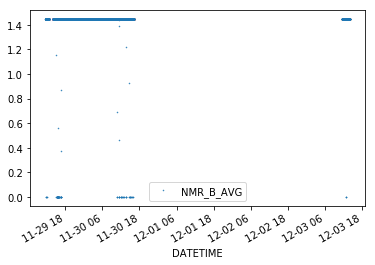

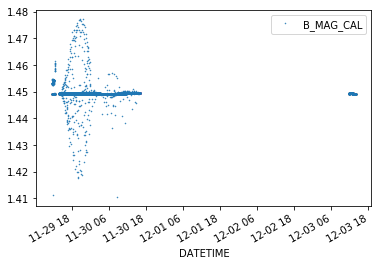

In [27]:
df.plot(x='DATETIME',y='NMR_B_AVG',linewidth=0,marker='.',markersize=1)
#plt.set_xticklabels(df['Run'].values)
df.plot(x='DATETIME',y='B_MAG_CAL',linewidth=0,marker='.',markersize=1)

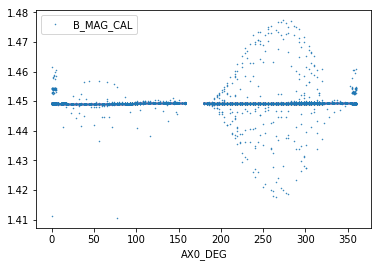

In [28]:
df.plot(x='AX0_DEG',y='B_MAG_CAL',linewidth=0,marker='.',markersize=1)

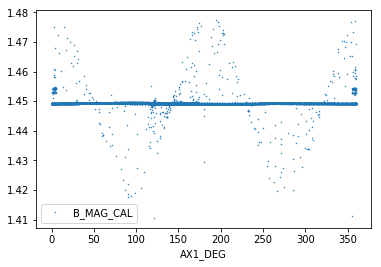

In [29]:
df.plot(x='AX1_DEG',y='B_MAG_CAL',linewidth=0,marker='.',markersize=1)

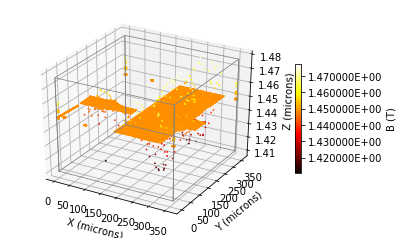

In [30]:
_ = Scatter3d(df.AX0_DEG,df.AX1_DEG,df.B_MAG_CAL, cs=df.B_MAG_CAL)

In [31]:
df.dtypes

DATETIME     datetime64[ns]
NMR_B_AVG           float64
FFT_MAX             float64
AX0_DEG             float64
AX1_DEG             float64
AX0_PAT             float64
AX1_PAT             float64
BX_RAW              float64
BY_RAW              float64
BZ_RAW              float64
B_MAG_RAW           float64
BX_CAL              float64
BY_CAL              float64
BZ_CAL              float64
B_MAG_CAL           float64
TEMP                float64
ID                   object
ID_NAME              object
Run                   int64
dtype: object

## NMR Cut on "Bad" Measurements

In [32]:
m = df.NMR_B_AVG.mean()
s = df.NMR_B_AVG.std()
gnmr =  ((m-0.5*s) < df.NMR_B_AVG) & (df.NMR_B_AVG < (m+0.5*s))

In [33]:
print(f"{len(df)} points ---> nmr cut ---> {len(df[gnmr])} points")

15902 points ---> nmr cut ---> 15794 points


In [34]:
df.NMR_B_AVG.describe()

count    15902.000000
mean         1.440044
std          0.115722
min          0.000000
25%          1.449498
50%          1.449498
75%          1.449498
max          1.449541
Name: NMR_B_AVG, dtype: float64

In [35]:
df[gnmr].NMR_B_AVG.describe()

count    15794.000000
mean         1.449495
std          0.000465
min          1.391518
25%          1.449498
50%          1.449498
75%          1.449498
max          1.449541
Name: NMR_B_AVG, dtype: float64

In [36]:
m_ = df[gnmr].NMR_B_AVG.mean()
s_ = df[gnmr].NMR_B_AVG.std()

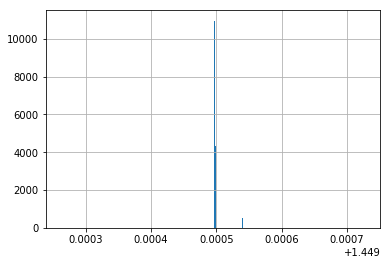

In [37]:
plt.figure()
df[gnmr].NMR_B_AVG.hist(bins=300,range=[m_-0.5*s_,m_+0.5*s_])
#plt.show()

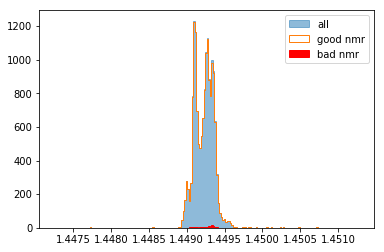

In [38]:
plt.figure()
m_b = df.B_MAG_CAL.mean()
s_b = df.B_MAG_CAL.std()
df.B_MAG_CAL.hist(bins=200,range=[m_b-1.0*s_b,m_b+1.0*s_b],
                  histtype='step',fill=True,alpha=0.5,label='all',
                  grid=False)
df[gnmr].B_MAG_CAL.hist(bins=200,range=[m_b-1.0*s_b,m_b+1.0*s_b],
                        histtype='step',fill=False,label='good nmr',
                        grid=False)
df[~gnmr].B_MAG_CAL.hist(bins=200,range=[m_b-1.0*s_b,m_b+1.0*s_b],
                        histtype='step',fill=True,label='bad nmr',
                        grid=False,color='red')
plt.legend()

In [39]:
df.B_MAG_CAL.describe()

count    15902.000000
mean         1.449266
std          0.002010
min          1.410521
25%          1.449113
50%          1.449238
75%          1.449320
max          1.477285
Name: B_MAG_CAL, dtype: float64

In [40]:
df[gnmr].B_MAG_CAL.describe()

count    15794.000000
mean         1.449265
std          0.002016
min          1.410521
25%          1.449113
50%          1.449238
75%          1.449320
max          1.477285
Name: B_MAG_CAL, dtype: float64

In [41]:
df[~gnmr].B_MAG_CAL.describe()

count    108.000000
mean       1.449340
std        0.000543
min        1.449040
25%        1.449175
50%        1.449291
75%        1.449346
max        1.454173
Name: B_MAG_CAL, dtype: float64

In [42]:
df[gnmr].describe()

,NMR_B_AVG,FFT_MAX,AX0_DEG,AX1_DEG,AX0_PAT,AX1_PAT,BX_RAW,BY_RAW,BZ_RAW,B_MAG_RAW,BX_CAL,BY_CAL,BZ_CAL,B_MAG_CAL,TEMP,Run
count,15794.000000,15794.000000,15794.000000,15794.000000,15794.000000,15794.000000,1.579400e+04,1.579400e+04,1.579400e+04,1.579400e+04,15794.000000,15794.000000,15794.000000,15794.000000,15794.000000,15794.000000
mean,1.449495,4.301325,170.889452,163.510759,0.283219,0.054294,1.055367e+06,-3.295797e+05,-1.811786e+05,4.082719e+06,0.062038,-0.120674,-0.377041,1.449265,23.975678,3.138977
std,0.000465,2.671415,109.968294,80.458378,99.340072,99.702221,2.163376e+06,1.613166e+06,2.851964e+06,4.331291e+04,1.000620,0.576708,0.778521,0.002016,0.438912,0.866800
min,1.391518,2.139970,0.000932,0.058362,-180.000000,-180.000000,-4.069778e+06,-4.100215e+06,-4.154924e+06,3.919176e+06,-1.448584,-1.449288,-1.449093,1.410521,21.977000,0.000000
25%,1.449498,3.878950,80.168056,145.493005,-80.168070,-80.168070,-5.010945e+05,-1.347554e+06,-3.034491e+06,4.049960e+06,-0.941731,-0.490677,-1.061113,1.449113,23.647000,3.000000
50%,1.449498,4.187533,157.129676,165.002247,0.131580,0.131580,1.495882e+06,-3.367920e+05,-1.422220e+05,4.074071e+06,0.045225,-0.120500,-0.525356,1.449238,23.872000,3.000000
75%,1.449498,4.580489,267.731087,171.195767,80.168060,80.168060,2.958694e+06,3.921475e+05,2.647841e+06,4.114035e+06,1.074652,0.135501,0.194518,1.449320,24.220000,3.000000
max,1.449541,236.072342,359.736846,359.998576,179.999990,179.999990,4.067358e+06,4.110439e+06,4.162751e+06,4.169297e+06,1.449302,1.448835,1.449191,1.477285,25.021000,7.000000


## Angle Definition Discrepancy

In [43]:
key = ["NMR","TEMP","CAL","DATE"]
cols = []
for f in df.columns:
    if any([k in f for k in key]):
        cols.append(f)
#cols = [f if ([k in f for k in key]) for f in df.columns]

In [44]:
cols

['DATETIME', 'NMR_B_AVG', 'BX_CAL', 'BY_CAL', 'BZ_CAL', 'B_MAG_CAL', 'TEMP']

In [45]:
x = [1,2,4,5]
b = [1,1,2,5,6,5,4,7]

In [46]:
list(filter(lambda y: y in x, b))

[1, 1, 2, 5, 5, 4]

In [47]:
df.groupby("Run")[["NMR_B_AVG","AX0_DEG","AX1_DEG"]].describe()

NMR_B_AVG                                                                  \
        count      mean           std       min       25%       50%       75%   
Run                                                                             
0         2.0  1.449541  2.104350e-09  1.449541  1.449541  1.449541  1.449541   
1       400.0  1.431422  1.612492e-01  0.000000  1.449541  1.449541  1.449541   
2       100.0  1.449541  4.241593e-08  1.449541  1.449541  1.449541  1.449541   
3     14400.0  1.439862  1.167347e-01  0.000000  1.449498  1.449498  1.449498   
4       100.0  1.449498  9.136962e-09  1.449498  1.449498  1.449498  1.449498   
5       100.0  1.449498  1.233442e-08  1.449498  1.449498  1.449498  1.449498   
6       400.0  1.438620  1.252147e-01  0.000000  1.449498  1.449498  1.449498   
7       400.0  1.449498  1.883291e-06  1.449461  1.449498  1.449498  1.449498   

               AX0_DEG                 ...                              \
          max    count        mean     ...             75%         max   
Run                                    ...                               
0    1.449541      2.0  354.999995     ...      354.999995  354.999996   
1    1.449541    400.0  179.999998     ...      357.236840  359.736846   
2    1.449541    100.0  179.999996     ...      357.222219  359.444442   
3    1.449498  14400.0  178.557740     ...      268.487394  358.487396   
4    1.449498    100.0   14.999999     ...       16.388890   17.500004   
5    1.449498    100.0  179.999998     ...      358.611107  359.722227   
6    1.449498    400.0    2.500932     ...        3.750934    5.000937   
7    1.449500    400.0   89.999998     ...       91.250000   92.500003   

     AX1_DEG                                                              \
       count        mean         std         min         25%         50%   
Run                                                                        
0        2.0  355.263156    0.372166  354.999995  355.131575  355.263156   
1      400.0  179.999998  177.596997    0.263150    2.763155  179.999999   
2      100.0  179.999996  178.122037    0.555548    2.777775  179.999996   
3    14400.0  166.778600   66.290657    0.058362  147.910248  166.488033   
4      100.0   14.999999    1.603752   12.499993   13.611110   15.000000   
5      100.0  179.999999  179.512656    0.277775    1.388889  179.999998   
6      400.0   50.898593   32.701939    0.261736   25.195952   50.130175   
7      400.0  179.999998  178.909586    0.131571    1.381576  179.999997   

                             
            75%         max  
Run                          
0    355.394737  355.526317  
1    357.236843  359.736846  
2    357.222218  359.444444  
3    169.917707  359.952649  
4     16.388887   17.500005  
5    358.611109  359.722226  
6     75.064392  359.998576  
7    358.618423  359.868424  

[8 rows x 24 columns]

In [48]:
def pRange(pSeries):
    return pSeries.max() - pSeries.min()

In [49]:
for r in df.Run.unique():
    rdf = df.query(f"Run == {r}")
    print(f"Run: {r}")
    print(f"AX0: {rdf.AX0_PAT.min()} -- {rdf.AX0_PAT.max()}, range: {pRange(rdf.AX0_PAT)}")
    print(f"AX1: {rdf.AX1_PAT.min()} -- {rdf.AX1_PAT.max()}, range: {pRange(rdf.AX1_PAT)}")
    print()

Run: 0
AX0: -5.0 -- -5.0, range: 0.0
AX1: -5.0 -- -4.473684, range: 0.5263159999999996

Run: 1
AX0: -5.0 -- 5.000004, range: 10.000004
AX1: -5.0 -- 5.000004, range: 10.000004

Run: 2
AX0: -5.0 -- 4.999999, range: 9.999998999999999
AX1: -5.0 -- 4.999999, range: 9.999998999999999

Run: 3
AX0: -180.0 -- 179.99999, range: 359.99999
AX1: -180.0 -- 179.99999, range: 359.99999

Run: 4
AX0: -2.5 -- 2.500004, range: 5.000004000000001
AX1: -2.5 -- 2.500004, range: 5.000004000000001

Run: 5
AX0: -2.5 -- 2.500004, range: 5.000004000000001
AX1: -2.5 -- 2.500004, range: 5.000004000000001

Run: 6
AX0: -2.5 -- 2.500002, range: 5.000002
AX1: -2.5 -- 2.500002, range: 5.000002

Run: 7
AX0: -2.5 -- 2.500002, range: 5.000002
AX1: -2.5 -- 2.500002, range: 5.000002



In [50]:
# FIXING ANGLES
df['AX0_DEG_2'] = pd.Series([row.AX0_DEG-360. if (row.AX0_PAT < 0) else row.AX0_DEG for row in df.itertuples()])
df['AX1_DEG_2'] = pd.Series([row.AX1_DEG-360. if (row.AX1_PAT < 0) else row.AX1_DEG for row in df.itertuples()])

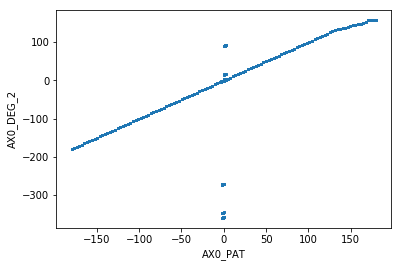

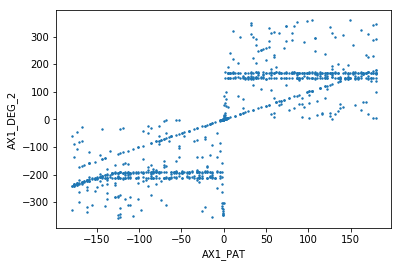

In [51]:
df.plot.scatter(x="AX0_PAT", y = "AX0_DEG_2", s=2)
df.sample(1000).plot.scatter(x="AX1_PAT", y = "AX1_DEG_2",s=2)

This second plot is quite concerning...

In [52]:
df.AX1_DEG.describe()

count    15902.000000
mean       163.764420
std         80.548416
min          0.058362
25%        145.786698
50%        164.992273
75%        171.466512
max        359.998576
Name: AX1_DEG, dtype: float64

In [53]:
df[['AX0_DEG','AX0_DEG_2','AX0_PAT']]

,AX0_DEG,AX0_DEG_2,AX0_PAT
0,354.999993,-5.000007,-5.000000
1,354.999996,-5.000004,-5.000000
2,354.999996,-5.000004,-5.000000
3,354.999996,-5.000004,-5.000000
4,354.999997,-5.000003,-5.000000
5,355.000004,-4.999996,-5.000000
6,354.999995,-5.000005,-5.000000
7,354.999997,-5.000003,-5.000000
8,354.999993,-5.000007,-5.000000
9,354.999995,-5.000005,-5.000000


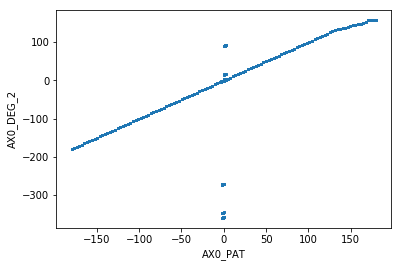

In [54]:
df.plot.scatter(x="AX0_PAT", y = "AX0_DEG_2", s=2)

## 3D Plotting Tests (Run 3)
- Run with most data and 2$\pi$ coverage in both axes (~1.5 deg step size)
- For prelim sampling data (2500 of 14400)

Now lets try to get a 3D plot of a B_RAW component in spherical coordinates (AX0 describes phi, AX1 describes theta, B_RAW describes r)

In [55]:
df3 = df.query("Run == 3").sample(2500)

In [56]:
df3[['AX0_PAT','AX0_DEG_2','AX1_PAT','AX1_DEG_2']].describe()

,AX0_PAT,AX0_DEG_2,AX1_PAT,AX1_DEG_2
count,2500.000000,2500.000000,2500.000000,2500.000000
mean,-0.924509,-2.323569,-0.974123,-11.601815
std,105.084111,102.932206,104.259912,183.447065
min,-180.000000,-180.000010,-180.000000,-357.029628
25%,-92.268910,-92.268913,-90.000003,-193.266603
50%,-1.512610,-1.512612,-1.512610,-4.537820
75%,89.243690,89.243689,89.243690,166.805913
max,179.999990,157.175504,179.999990,359.032101


Note that a large percentage of the useful angular datapoints from ANL are in run 3!

In [57]:
len(df)

15902

In [58]:
PHI = np.array(df3.AX0_PAT)
THETA = np.array(df3.AX1_PAT)
R = np.array(df3.BX_RAW.abs())

In [59]:
X = R * np.sin(THETA) * np.cos(PHI)
Y = R * np.sin(THETA) * np.sin(PHI)
Z = R * np.cos(THETA)

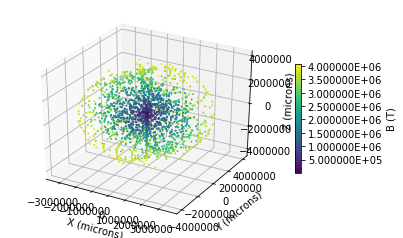

In [60]:
_ = Scatter3d(X,Y,Z,R,colorsMap='viridis',
             outline=False, alpha=1,psize=1)

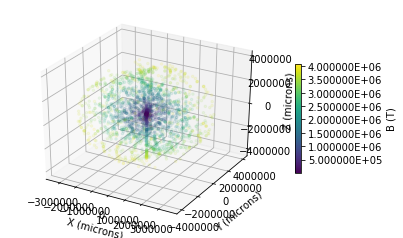

In [61]:
_ = Scatter3d(X,Y,Z,R,colorsMap='viridis',
             outline=False, alpha=0.1,psize=6)

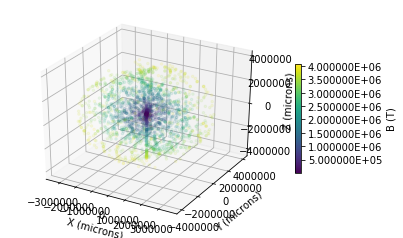

In [62]:
_ = Scatter3d(X,Y,Z,R,colorsMap='viridis',
             outline=False, alpha=0.1,psize=6)

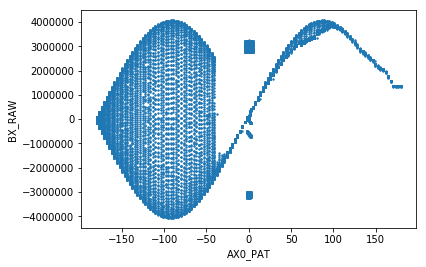

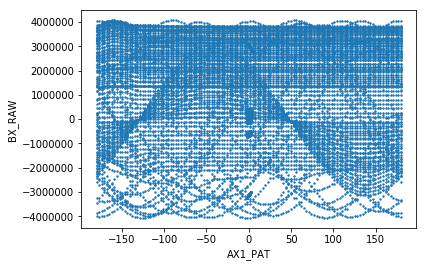

In [63]:
df.plot.scatter(x="AX0_PAT", y="BX_RAW", s=2)
df.plot.scatter(x="AX1_PAT", y="BX_RAW", s=2)

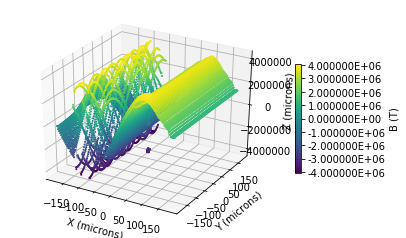

In [64]:
_ = Scatter3d(df.AX0_PAT,df.AX1_PAT,df.BX_RAW,
              cs=df.BX_RAW,colorsMap='viridis',outline=False,psize=1)

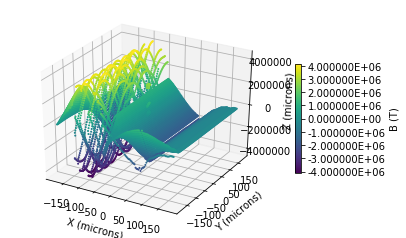

In [65]:
_ = Scatter3d(df.AX0_PAT,df.AX1_PAT,df.BY_RAW,
              cs=df.BY_RAW,colorsMap='viridis',outline=False,psize=1)

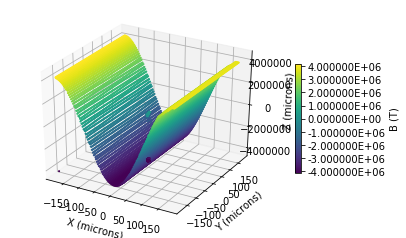

In [66]:
_ = Scatter3d(df.AX0_PAT,df.AX1_PAT,df.BZ_RAW,
              cs=df.BZ_RAW,colorsMap='viridis',outline=False,psize=1)

## Fixing FFT_MAX Import Error

In [67]:
r3 = df.Run == 3
df3 = df[r3]

In [68]:
_,m_ = HallRawDataFrame('datafiles/raw.ckampa.hallprobecal.tagMA12421.2018-11-29_135237', frompickle=True)

In [69]:
_.FFT_MAX.describe()

count    14390.000000
mean         4.255266
std          0.673045
min          0.000000
25%          3.885680
50%          4.195499
75%          4.587687
max         18.201460
Name: FFT_MAX, dtype: float64

In [70]:
_.FFT_MAX.isna().sum()

10

In [71]:
_.columns

Index(['DATETIME', 'NMR_B_AVG', 'FFT_MAX', 'AX0_DEG', 'AX1_DEG', 'AX0_PAT',
       'AX1_PAT', 'BX_RAW', 'BY_RAW', 'BZ_RAW', 'B_MAG_RAW', 'BX_CAL',
       'BY_CAL', 'BZ_CAL', 'B_MAG_CAL', 'TEMP', 'ID', 'ID_NAME'],
      dtype='object')

In [72]:
np.max(np.array([1,2,3,4]))

4

In [73]:
#import pdb

In [74]:
#pdb.run("HallRawDataFrame('datafiles/raw.ckampa.hallprobecal.tagMA12421.2018-11-29_135237', makepickle=True)")

## Run 3 Gen Plots

In [154]:
#df3 = df.query('Run == 3').reset_index(drop=True)
df3 = df.query('Run == 4').reset_index(drop=True)
#df3 = df.query('Run == 7').reset_index(drop=True)
len(df3)

100

### Angle vs. Time

In [155]:
trace1 = go.Scatter(x=df3.DATETIME,y=df3.AX0_PAT)
trace2 = go.Scatter(x=df3.DATETIME,y=df3.AX0_DEG)

data = [trace1,trace2]

iplot(data, filename="ax0_vs_time")

In [156]:
trace1 = go.Scatter(x=df3.DATETIME,y=df3.AX1_PAT)
trace2 = go.Scatter(x=df3.DATETIME,y=df3.AX1_DEG)

data = [trace1,trace2]

iplot(data, filename="ax1_vs_time")

### $B_i$ vs. $\theta,\phi$ 

In [137]:
#df3 = df.query('Run == 3').sample(1000)

s = 2

trace11 = go.Scatter(x=df3.AX0_PAT,y=df3.BX_CAL)#, mode = 'markers', marker = dict(size = s))
trace12 = go.Scatter(x=df3.AX1_PAT,y=df3.BX_CAL)#, mode = 'markers', marker = dict(size = s))
trace21 = go.Scatter(x=df3.AX0_PAT,y=df3.BY_CAL)#, mode = 'markers', marker = dict(size = s))
trace22 = go.Scatter(x=df3.AX1_PAT,y=df3.BY_CAL)#, mode = 'markers', marker = dict(size = s))
trace31 = go.Scatter(x=df3.AX0_PAT,y=df3.BZ_CAL)#, mode = 'markers', marker = dict(size = s))
trace32 = go.Scatter(x=df3.AX1_PAT,y=df3.BZ_CAL)#, mode = 'markers', marker = dict(size = s))
trace41 = go.Scatter(x=df3.AX0_PAT,y=df3.B_MAG_CAL)#, mode = 'markers', marker = dict(size = s))
trace42 = go.Scatter(x=df3.AX1_PAT,y=df3.B_MAG_CAL)#, mode = 'markers', marker = dict(size = s))

fig = tools.make_subplots(rows=4, cols=2, subplot_titles=('Bx vs. AX0', 'Bx vs. AX1',
                                                          'By vs. AX0', 'By vs. AX1',
                                                          'Bz vs. AX0', 'Bz vs. AX1',
                                                          'B_mag vs. AX0', 'B_mag vs. AX1'))

fig.append_trace(trace11, 1,1)
fig.append_trace(trace12, 1,2)
fig.append_trace(trace21, 2,1)
fig.append_trace(trace22, 2,2)
fig.append_trace(trace31, 3,1)
fig.append_trace(trace32, 3,2)
fig.append_trace(trace41, 4,1)
fig.append_trace(trace42, 4,2)


fig['layout']['xaxis1'].update(title='AX0 (deg)')
fig['layout']['xaxis2'].update(title='AX1 (deg)')
fig['layout']['xaxis3'].update(title='AX0 (deg)')
fig['layout']['xaxis4'].update(title='AX1 (deg)')
fig['layout']['xaxis5'].update(title='AX0 (deg)')
fig['layout']['xaxis6'].update(title='AX1 (deg)')
fig['layout']['xaxis7'].update(title='AX0 (deg)')
fig['layout']['xaxis8'].update(title='AX1 (deg)')

fig['layout']['yaxis1'].update(title='B (T)')
fig['layout']['yaxis2'].update(title='B (T)')
fig['layout']['yaxis3'].update(title='B (T)')
fig['layout']['yaxis4'].update(title='B (T)')
fig['layout']['yaxis5'].update(title='B (T)')
fig['layout']['yaxis6'].update(title='B (T)')
fig['layout']['yaxis7'].update(title='B (T)')
fig['layout']['yaxis8'].update(title='B (T)')


fig['layout'].update(height=1200, width=1000, title='ANL Run 3 (11/29/18 13:52)', showlegend=False)

plot(fig, filename='B_vs_Angles')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]
[ (4,1) x7,y7 ]  [ (4,2) x8,y8 ]



/home/ckampa/anaconda3/envs/bfitter/lib/python3.6/site-packages/plotly/offline/offline.py:621: UserWarning:

Your filename `B_vs_Angles` didn't end with .html. Adding .html to the end of your file.



'file:///home/ckampa/Coding/hallprobecalib/scripts/B_vs_Angles.html'

### Histograms

In [178]:
trace1 = go.Histogram(x=df.B_MAG_CAL, nbinsx=10, opacity=0.75)
trace2 = go.Histogram(x=df3.B_MAG_CAL, nbinsx=10, opacity=1.)

data = [trace2]

layout = go.Layout(
    title='Run 3: Calibrated B_mag',
    xaxis= dict(
        title='B (T)'
    ),
    yaxis=dict(
        title='Counts',
        type='log',
        autorange=True
    ),
    barmode='overlay',
    annotations=[
        dict(
            x=df3.B_MAG_CAL.max()-5*df3.B_MAG_CAL.std(),
            y=5,
            text=f'mean: {df3.B_MAG_CAL.mean()}<br>std:{df3.B_MAG_CAL.std()}<br>range: {df3.B_MAG_CAL.max()-df3.B_MAG_CAL.min()}',
            showarrow=False,
            font=dict(
                family='Courier New, monospace',
                size=16,
                color='#000000'
            ),
            bordercolor='#c7c7c7',
            borderwidth=2,
            borderpad=4,
            bgcolor='#ffffff',
            opacity=0.8
        )
    ]
)

fig = go.Figure(data=data, layout=layout)

plot(fig, filename='histo_B_MAG_run3')
#iplot(data, filename='h_B_MAG_RAW')

/home/ckampa/anaconda3/envs/bfitter/lib/python3.6/site-packages/plotly/offline/offline.py:621: UserWarning:

Your filename `histo_B_MAG_run3` didn't end with .html. Adding .html to the end of your file.



'file:///home/ckampa/Coding/hallprobecalib/scripts/histo_B_MAG_run3.html'

### Trisurf Plot

<IPython.core.display.Javascript object>


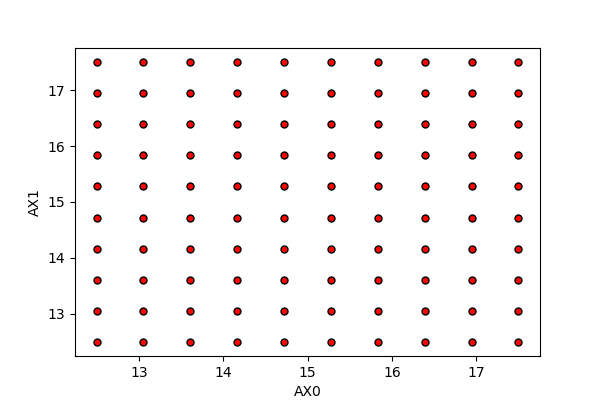

Text(0,0.5,'AX1')

In [179]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

x = df3.AX0_DEG
y = df3.AX1_DEG
z = df3.B_MAG_CAL

ax.scatter(x, y, marker='.', c='red', edgecolors='black', s=100)
ax.set_xlabel('AX0')
ax.set_ylabel('AX1')

In [183]:
triang = mtri.Triangulation(x,y)
triang.triangles

array([[69,  9, 29],
       [19, 29,  9],
       [92, 90, 93],
       [92, 91, 90],
       [ 4,  0,  3],
       [ 0,  2,  3],
       [ 3,  2, 13],
       [ 3, 14,  4],
       [13, 14,  3],
       [ 1,  2,  0],
       [ 4, 14,  5],
       [93, 97, 95],
       [47, 46, 57],
       [88, 98, 99],
       [69, 29, 59],
       [29, 49, 59],
       [29, 19, 18],
       [18, 28, 29],
       [ 6,  7,  4],
       [ 4,  5,  6],
       [15,  5, 14],
       [25, 35, 26],
       [80, 70, 90],
       [93, 95, 94],
       [94, 95, 84],
       [96, 95, 97],
       [93, 94, 83],
       [83, 94, 84],
       [83, 92, 93],
       [58, 59, 49],
       [66, 75, 76],
       [89, 88, 99],
       [87, 96, 97],
       [97, 98, 87],
       [98, 88, 87],
       [84, 75, 74],
       [74, 83, 84],
       [73, 83, 74],
       [76, 75, 85],
       [95, 96, 85],
       [84, 95, 85],
       [85, 75, 84],
       [28, 18, 27],
       [36, 46, 47],
       [47, 37, 36],
       [26, 35, 36],
       [36, 27, 26],
       [37, 2

<IPython.core.display.Javascript object>


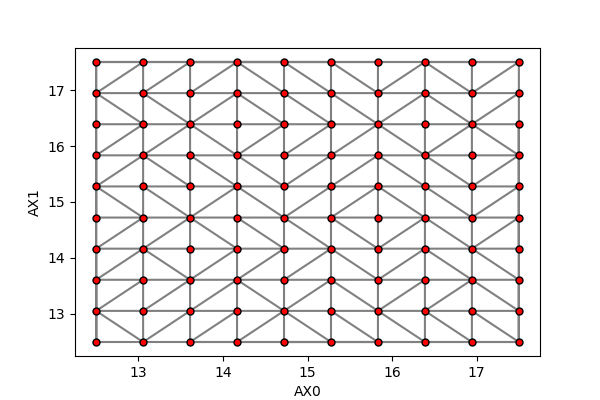

Text(0,0.5,'AX1')

In [184]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.triplot(triang, c='gray', marker='.', markerfacecolor='red', markeredgecolor='black', markersize=10)

ax.set_xlabel('AX0')
ax.set_ylabel('AX1')

<IPython.core.display.Javascript object>


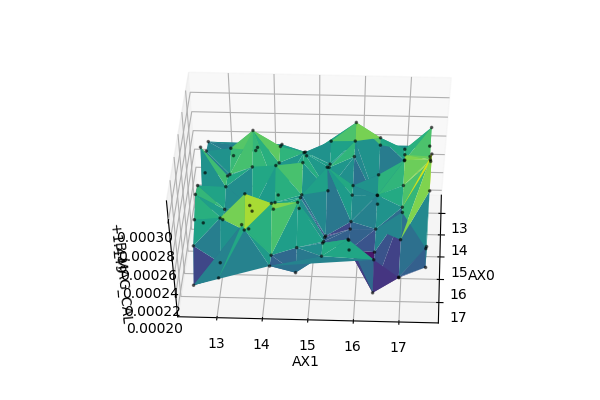

Text(0.5,0,'B_MAG_CAL')

In [186]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

ax.plot_trisurf(triang, z, cmap='viridis')
ax.scatter(x,y,z, marker='.', s=10, c='black', alpha=0.5)
ax.view_init(elev=60, azim=-45)

ax.set_xlabel("AX0")
ax.set_ylabel("AX1")
ax.set_zlabel("B_MAG_CAL")

### Surface Plot

In [164]:
x1 = np.linspace(df3['AX0_DEG'].min(), df3['AX0_DEG'].max(), len(df3['AX0_PAT'].unique()))
y1 = np.linspace(df3['AX1_DEG'].min(), df3['AX1_DEG'].max(), len(df3['AX1_PAT'].unique()))

x2, y2 = np.meshgrid(x1, y1)

In [ ]:
z2 = griddata((df3['AX0_DEG'],df3['AX1_DEG']), df['B_MAG_CAL'], (x2,y2), method='cubic')

In [157]:
#x = df3.AX0_PAT.unique()
#y = df3.AX1_PAT.unique()
#z = np.array(df3.B_MAG_CAL)
x = df3.AX0_DEG.unique()
y = df3.AX1_DEG.unique()
z = np.array(df3.B_MAG_RAW)

#B_min = 1.44
#B_max = 1.46

#z = [i if i<=B_max else B_max for i in z]
#z = [i if i>=B_min else B_min for i in z]

In [158]:
# 'ij' indexing is important!!!!
xx,yy = np.meshgrid(x,y,indexing='ij')
zz = np.reshape(z,(len(x),len(y)))

ValueError: cannot reshape array of size 100 into shape (59,68)

In [141]:
data = [go.Surface(x=xx,y=yy,z=zz, opacity=0.8, colorscale="Viridis")]

layout = go.Layout(
    title='Calibrated B_mag vs. Angle',
    scene = dict(
    xaxis= dict(
        title='AX0 (deg)'
    ),
    yaxis=dict(
        title='AX1 (deg)'
    ),
    zaxis=dict(
        title='B_mag (T)'
    )
    )
)

'''autosize=False,
    width=600,
    height=600,
    margin=dict(l=0,r=0,b=0,t=0)'''

fig = go.Figure(data=data, layout=layout)

In [142]:
plot(fig, filename='B_vs_angle_surf')

/home/ckampa/anaconda3/envs/bfitter/lib/python3.6/site-packages/plotly/offline/offline.py:621: UserWarning:

Your filename `B_vs_angle_surf` didn't end with .html. Adding .html to the end of your file.



'file:///home/ckampa/Coding/hallprobecalib/scripts/B_vs_angle_surf.html'

### Trace On Angle ###

In [124]:
df3.head()

,DATETIME,NMR_B_AVG,FFT_MAX,AX0_DEG,AX1_DEG,AX0_PAT,AX1_PAT,BX_RAW,BY_RAW,BZ_RAW,...,BX_CAL,BY_CAL,BZ_CAL,B_MAG_CAL,TEMP,ID,ID_NAME,Run,AX0_DEG_2,AX1_DEG_2
0,2018-12-03 11:36:37,1.449498,3.780596,12.499997,12.500001,-2.5,-2.500000,-540517.0,805635.0,-4019099.0,...,1.404672,0.283936,0.215921,1.449257,24.267,C80000000D554B3A,linus,4,-347.500003,-347.499999
1,2018-12-03 11:36:40,1.449498,5.325963,12.500004,13.055557,-2.5,-1.944444,-532883.0,811331.0,-4019148.0,...,1.404668,0.285996,0.213115,1.449242,24.268,C80000000D554B3A,linus,4,-347.499996,-346.944443
2,2018-12-03 11:36:44,1.449498,4.168296,12.499999,13.611111,-2.5,-1.388888,-525242.0,816891.0,-4019276.0,...,1.404690,0.288007,0.210307,1.449252,24.269,C80000000D554B3A,linus,4,-347.500001,-346.388889
3,2018-12-03 11:36:48,1.449498,4.212131,12.499995,14.166664,-2.5,-0.833332,-517653.0,822510.0,-4019338.0,...,1.404690,0.290040,0.207517,1.449256,24.271,C80000000D554B3A,linus,4,-347.500005,-345.833336
4,2018-12-03 11:36:51,1.449498,3.751941,12.499992,14.722216,-2.5,-0.277776,-510000.0,828018.0,-4019368.0,...,1.404678,0.292032,0.204704,1.449244,24.270,C80000000D554B3A,linus,4,-347.500008,-345.277784


In [125]:
d = df3.DATETIME[0]
d2 = df3.loc[df3['DATETIME'] == d]
print(f'{d}, {d2}')

2018-12-03 11:36:37,              DATETIME  NMR_B_AVG   FFT_MAX    AX0_DEG    AX1_DEG  AX0_PAT  \
0 2018-12-03 11:36:37   1.449498  3.780596  12.499997  12.500001     -2.5   

   AX1_PAT    BX_RAW    BY_RAW     BZ_RAW     ...        BX_CAL    BY_CAL  \
0     -2.5 -540517.0  805635.0 -4019099.0     ...      1.404672  0.283936   

     BZ_CAL  B_MAG_CAL    TEMP                ID ID_NAME Run   AX0_DEG_2  \
0  0.215921   1.449257  24.267  C80000000D554B3A   linus   4 -347.500003   

    AX1_DEG_2  
0 -347.499999  

[1 rows x 21 columns]


In [126]:
s = 10

def ax0():
    return widgets.SelectionSlider(
    options=sorted(df3.AX0_PAT.unique()),
    value=df3.AX0_PAT.min(),
    description='AX0:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True)

def ax1():
    return widgets.SelectionSlider(
    options=sorted(df3.AX1_PAT.unique()),
    value=df3.AX1_PAT.min(),
    description='AX1:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True)

# full trace, line plot, low opacity
def view_image(const_axis,B,cal,i,j):
    #dat = df3.loc[df3['DATETIME'] == d]
    if const_axis == 'AX0_PAT':
        ax2 = 'AX1_PAT'
        a0 =  i #df3[const_axis].unique()[i]
        a2 = j
    else:
        ax2 = 'AX0_PAT'
        a0 = j#df3[const_axis].unique()[j]
        a2 = i
        #tr1 = df3.query(f'{const_ax} == {a0}').reset_index(drop=True)
        #dat = tr1.iloc[i]

    tr1 = df3.query(f'{const_axis} == {a0}').reset_index(drop=True)
    dat = tr1.query(f'{ax2} == {a2}')

    B = B+"_"+cal
    #a0 = dat[ax]
    #tr1 = df3.query(f'{ax} == {a0}')
    trace1 = go.Scatter(x=tr1[ax2],y=tr1[B], opacity=0.75) #, name=f'{const_axis} = {a0}')
    #scat1 = go.Scatter(x=df3.AX0_PAT[i],y=df3.BX_CAL[i], mode = 'markers', marker = dict(size = s))
    scat1 = go.Scatter(x=np.array(dat[ax2]),y=np.array(dat[B]), 
                       mode = 'markers',
                       marker = dict(size = s,
                                     color = '#d92626'),
                       name=f'{ax2} = {dat[ax2]}')
    layout = go.Layout(
    title='Run 3: Calibrated B_mag',
    xaxis= dict(
        title=f'{ax2} (deg)'
    ),
    yaxis=dict(
        title=f'{B} (T)'
        #type='log',
        #autorange=True
    ))
    fig = go.Figure(data=[trace1,scat1], layout=layout)
    iplot(fig)
interact(view_image, B = ['B_MAG','BX','BY','BZ'], cal=['CAL','RAW'], const_axis =['AX0_PAT','AX1_PAT'],i=ax0(),j=ax1())

interactive(children=(Dropdown(description='const_axis', options=('AX0_PAT', 'AX1_PAT'), value='AX0_PAT'), Dro…

<function __main__.view_image(const_axis, B, cal, i, j)>

In [87]:

df3.index

RangeIndex(start=0, stop=14400, step=1)

In [88]:
widgets.FloatSlider()

FloatSlider(value=0.0)